# Plot CSON

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy
import cartopy.crs as ccrs

import cmocean

In [43]:
import yaml


def find_grid_yaml_files(blueprints_dir):
    # Recursively find blueprint_*.yml files
    blueprint_files = list(blueprints_dir.rglob("blueprint_*.yml"))

    blueprint_files = [l for l in blueprint_files if ".ipynb_checkpoints" not in str(l)]

    grid_yaml_paths = []
    grid_names = []
    for bpfile in blueprint_files:
        try:
            print(f"\n--- Reading blueprint YAML file: {bpfile} ---")
            with open(bpfile, "r") as f:
                meta = yaml.safe_load(f)
            grid_names.append(meta["grid_name"])
            grid_yaml_path = Path(meta["inputs"]["grid"]["yaml_file"])
            print(f"  Found grid yaml_file reference: {grid_yaml_path}")
          
            
            if grid_yaml_path.exists():
                grid_yaml_paths.append(grid_yaml_path)
        except Exception as e:
            print(f"Could not parse {bpfile}: {e}")
    return grid_names, grid_yaml_paths

grid_names, grid_yamls = find_grid_yaml_files(config.paths.here / "blueprints")
grids = {}
for name,  f in zip(grid_names, grid_yamls):
    grids[name] = rt.Grid.from_yaml(f)

grids

2025-11-23 18:42:45 - WARNING - Current roms-tools version (3.2.0) does not match the version in the YAML header (3.1.3.dev13+g2830da646).



--- Reading blueprint YAML file: /Users/mclong/codes/cson-forge/workflows/blueprints/roms-marbl_gulf-guinea-toy/blueprint_roms-marbl-gulf-guinea-toy.yml ---
  Found grid yaml_file reference: /Users/mclong/codes/cson-forge/workflows/blueprints/roms-marbl_gulf-guinea-toy/_grid.yml

--- Reading blueprint YAML file: /Users/mclong/codes/cson-forge/workflows/blueprints/roms-marbl_wio-toy/blueprint_roms-marbl-wio-toy.yml ---
  Found grid yaml_file reference: /Users/mclong/codes/cson-forge/workflows/blueprints/roms-marbl_wio-toy/_grid.yml


2025-11-23 18:42:46 - WARNING - Current roms-tools version (3.2.0) does not match the version in the YAML header (3.1.3.dev13+g2830da646).


{'gulf-guinea-toy': Grid(nx=10, ny=10, size_x=4000, size_y=2000, center_lon=4.0, center_lat=-1.0, rot=0, N=5, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=True),
 'wio-toy': Grid(nx=20, ny=20, size_x=8000, size_y=8000, center_lon=60.0, center_lat=-4.0, rot=0, N=10, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=False)}

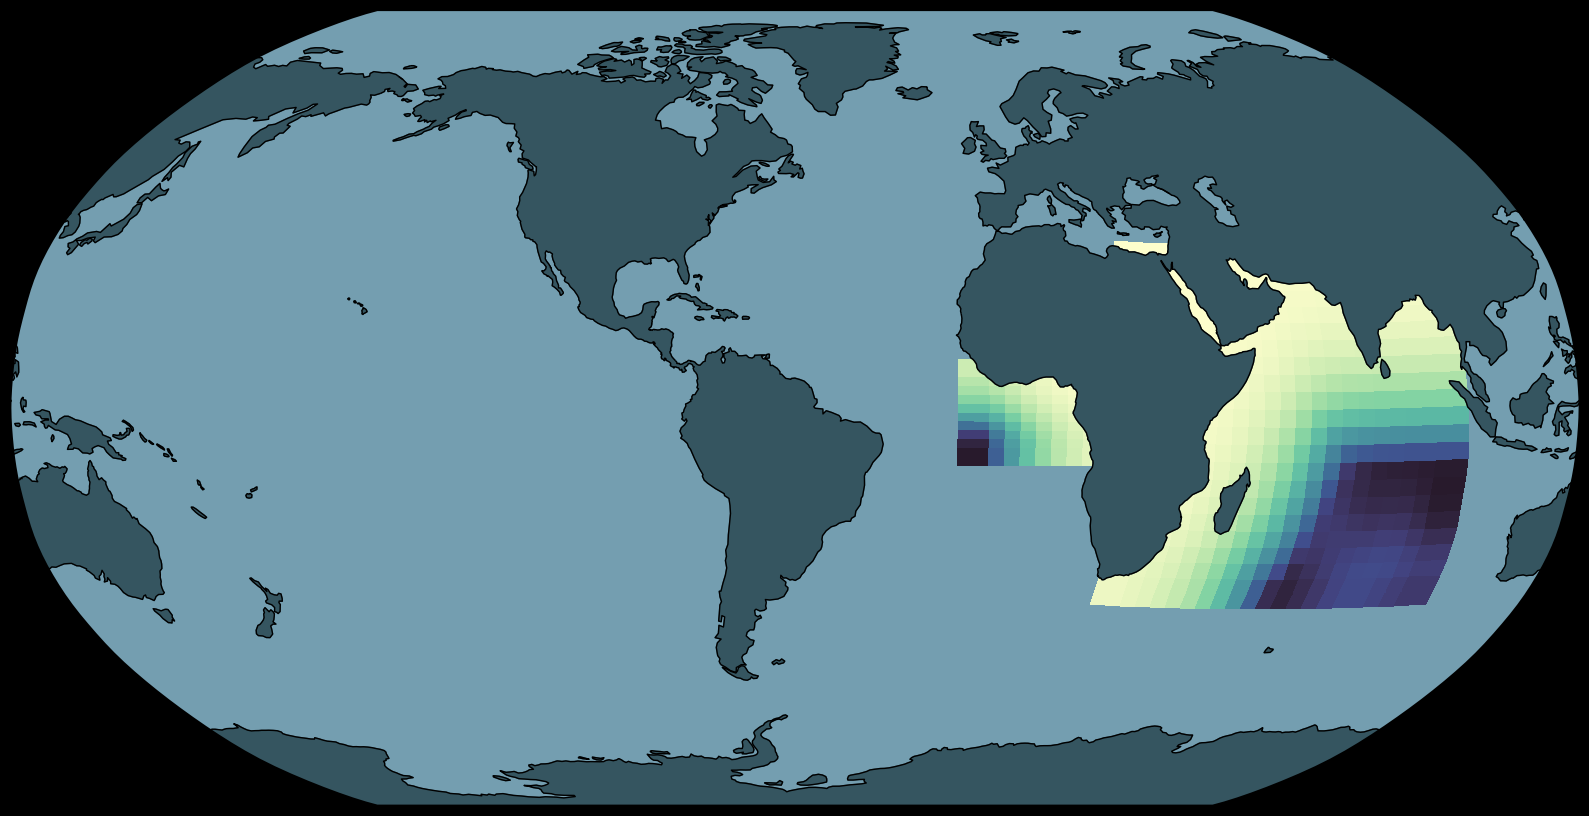

In [44]:
prj = ccrs.Robinson(central_longitude=305.0)

fig, ax = plt.subplots(
    figsize=(12, 12),
    facecolor='k',
    subplot_kw=dict(projection=prj),
)

ocean = ax.add_feature(
    cartopy.feature.NaturalEarthFeature(
        'physical','ocean','110m',
        edgecolor='face',
        facecolor='#749EB0',
        zorder=-9999,
    )
)

land = ax.add_feature(
     cartopy.feature.NaturalEarthFeature(
         'physical','land','110m',
         edgecolor='face',
         facecolor='#355560'
     )
 )

ax.coastlines()

ax.spines['geo'].set_visible(True)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

for g in grids.values():
    ax.pcolormesh(
        g.ds.lon_rho, g.ds.lat_rho, g.ds.h, 
        #edgecolors='k', linewidth=0.25,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.deep,
    )
    
ax.set_global() # For a global map

fig_size = (16, 9)
fig.set_size_inches(fig_size)
fig.tight_layout()

fig.savefig('cson.png', dpi=300, transparent=True)
   

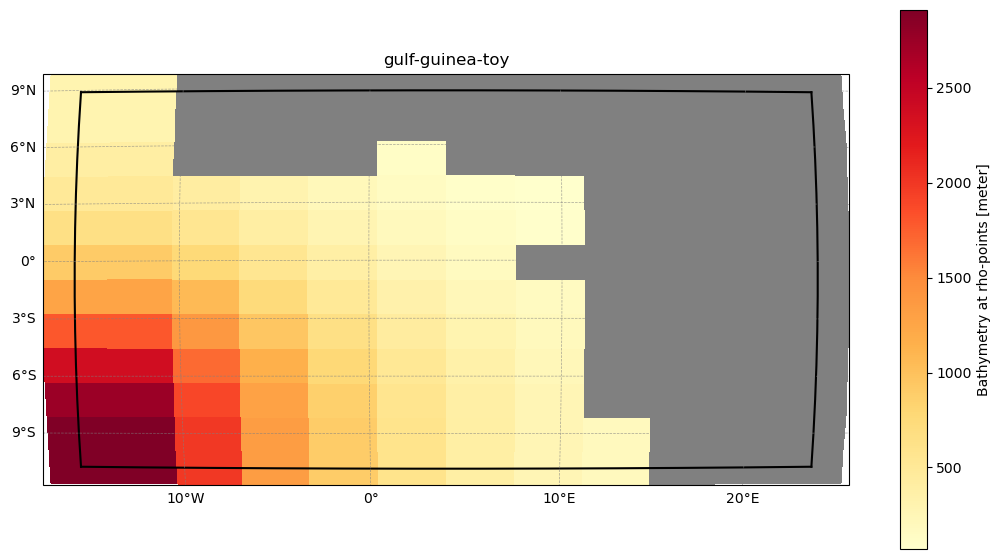

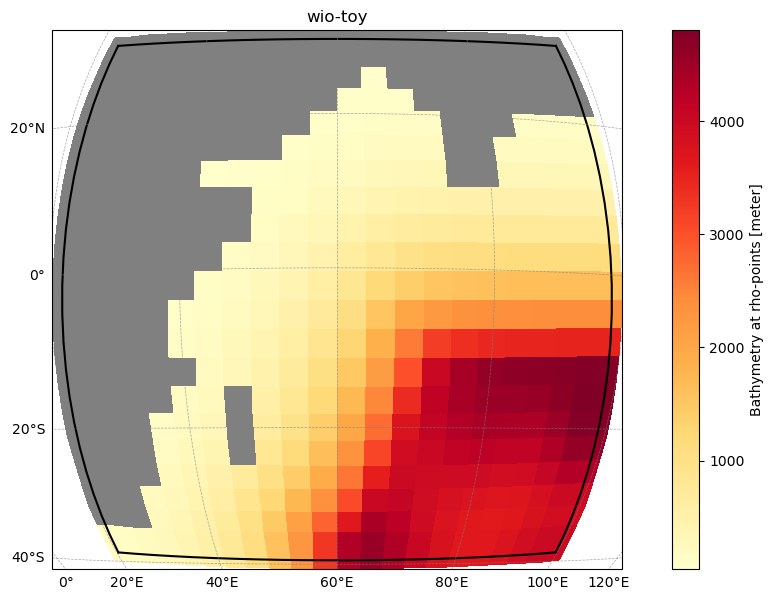

In [45]:
for name, g in grids.items():
    rt.plot.plot(g.ds.h, g.ds) # , ax=ax) passing an axis is broken https://github.com/CWorthy-ocean/roms-tools/issues/489
    plt.gca().set_title(name)